##Библиотеки и данные


In [1]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import warnings
from typing import Union, Dict, Set, List
from torch.nn.functional import log_softmax
import re
from torch.cuda.amp import GradScaler, autocast
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [2]:
!pip install kaggle
!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech
!unzip -o -q darpa-timit-acousticphonetic-continuous-speech.zip -d timit/

Dataset URL: https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech
License(s): copyright-authors
100% 828M/829M [00:37<00:00, 32.7MB/s]
100% 829M/829M [00:37<00:00, 23.4MB/s]


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##Основной код

In [4]:
class TimitDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.uri2wav = {}
        self.uri2text = {}
        for d, _, fs in os.walk(data_path):
            for f in fs:
                full_path = f'{d}/{f}'
                if f.endswith('.wav'):
                    stem = Path(f[:-4]).stem
                    self.uri2wav[f'{d}/{stem}'] = full_path
                elif f.endswith('.TXT'):
                    stem = Path(f).stem
                    self.uri2text[f'{d}/{stem}'] = full_path
                else:
                    pass

        self.uris = list(sorted(set(self.uri2wav.keys()) & set(self.uri2text.keys())))
        print(f"Found {len(self.uris)} utterances in {self.data_path}.")

    def get_uri(self, index_or_uri: Union[str, int]):
        if isinstance(index_or_uri, str):
            uri = index_or_uri
        else:
            uri = self.uris[index_or_uri]
        return uri

    def get_audio(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        wav_path = self.uri2wav[uri]
        wav_channels, sr = torchaudio.load(wav_path)
        return wav_channels[0], sr

    def get_text(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        txt_path = self.uri2text[uri]
        with open(txt_path) as f:
            _, _, text = f.read().strip().split(maxsplit=2)
        return text.strip()

    def __getitem__(self, index):
        audio, sr = self.get_audio(index)
        text = self.get_text(index)
        return {"audio": audio, "sr": sr, "text": text}

    def __len__(self):
        return len(self.uris)

In [5]:
def tokenize(text, vocab):
    return [vocab[char] for char in text]

def build_vocab(dataset):
    vocab = {'<blank>': 0}
    for i in range(len(dataset)):
        text = dataset[i]['text']
        for char in text:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

In [6]:
def collate_fn(batch, vocab):
    audios = [item['audio'] for item in batch]
    texts = [tokenize(item['text'], vocab) for item in batch]
    audio_lens = torch.tensor([len(audio) for audio in audios], dtype=torch.long)
    text_lens = torch.tensor([len(text) for text in texts], dtype=torch.long)
    audios = nn.utils.rnn.pad_sequence(audios, batch_first=True)
    texts = nn.utils.rnn.pad_sequence([torch.tensor(t) for t in texts], batch_first=True)
    return audios, audio_lens, texts, text_lens

In [7]:
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=40,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
).to(device)

In [46]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [9]:
def prepare_dataloader(dataset_path, batch_size):
    dataset = TimitDataset(dataset_path)
    vocab = build_vocab(dataset)
    dataloader = DataLoader(
    dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, vocab), num_workers=4
)
    return dataloader, vocab

In [10]:
def setup_training(input_dim, hidden_dim, output_dim, lr):
    model = SpeechRecognitionModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)

    return model, optimizer, criterion

In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for audios, audio_lens, texts, text_lens in tqdm(dataloader, desc="Training"):
        audios, texts, audio_lens, text_lens = (
            audios.to(device),
            texts.to(device),
            audio_lens.to(device),
            text_lens.to(device),
        )

        audios = torch.stack([mfcc_transform(audio) for audio in audios])
        audio_lens = audio_lens // audios.shape[2]
        audios = audios.permute(0, 2, 1)

        logits = model(audios)
        log_probs = nn.functional.log_softmax(logits, dim=2).transpose(0, 1)
        loss = criterion(log_probs, texts, audio_lens, text_lens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [12]:
def plot_loss(loss_history):
    plt.plot(range(len(loss_history)), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

##Обучение

In [ ]:
def train_model(dataset_path, epochs=50, batch_size=32, lr=0.001):
    dataloader, vocab = prepare_dataloader(dataset_path, batch_size)
    model, optimizer, criterion = setup_training(input_dim=40, hidden_dim=256, output_dim=len(vocab), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_history = []
    for epoch in range(epochs):
        epoch_loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), 'speech_recognition_model.pth')
    plot_loss(loss_history)

    return model, vocab


Found 4620 utterances in /content/timit/data/TRAIN.


Epoch 1: 100%|██████████| 145/145 [01:03<00:00,  2.27it/s]


Epoch 1, Loss: 3.1843


Epoch 2: 100%|██████████| 145/145 [00:58<00:00,  2.49it/s]


Epoch 2, Loss: 2.9945


Epoch 3: 100%|██████████| 145/145 [00:57<00:00,  2.53it/s]


Epoch 3, Loss: 2.9231


Epoch 4: 100%|██████████| 145/145 [00:58<00:00,  2.50it/s]


Epoch 4, Loss: 2.8542


Epoch 5: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 5, Loss: 2.7901


Epoch 6: 100%|██████████| 145/145 [00:57<00:00,  2.52it/s]


Epoch 6, Loss: 2.7352


Epoch 7: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 7, Loss: 2.6897


Epoch 8: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 8, Loss: 2.6467


Epoch 9: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 9, Loss: 2.6084


Epoch 10: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 10, Loss: 2.5756


Epoch 11: 100%|██████████| 145/145 [00:57<00:00,  2.50it/s]


Epoch 11, Loss: 2.5463


Epoch 12: 100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Epoch 12, Loss: 2.5272


Epoch 13: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 13, Loss: 2.5027


Epoch 14: 100%|██████████| 145/145 [00:58<00:00,  2.49it/s]


Epoch 14, Loss: 2.4738


Epoch 15: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 15, Loss: 2.4495


Epoch 16: 100%|██████████| 145/145 [00:59<00:00,  2.44it/s]


Epoch 16, Loss: 2.4307


Epoch 17: 100%|██████████| 145/145 [00:58<00:00,  2.50it/s]


Epoch 17, Loss: 2.4291


Epoch 18: 100%|██████████| 145/145 [00:58<00:00,  2.48it/s]


Epoch 18, Loss: 2.3995


Epoch 19: 100%|██████████| 145/145 [00:57<00:00,  2.50it/s]


Epoch 19, Loss: 2.3750


Epoch 20: 100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Epoch 20, Loss: 2.3642


Epoch 21: 100%|██████████| 145/145 [00:58<00:00,  2.48it/s]


Epoch 21, Loss: 2.3467


Epoch 22: 100%|██████████| 145/145 [00:57<00:00,  2.50it/s]


Epoch 22, Loss: 2.3349


Epoch 23: 100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Epoch 23, Loss: 2.3397


Epoch 24: 100%|██████████| 145/145 [00:57<00:00,  2.51it/s]


Epoch 24, Loss: 2.3253


Epoch 25: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 25, Loss: 2.2999


Epoch 26: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 26, Loss: 2.2905


Epoch 27: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 27, Loss: 2.2869


Epoch 28: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 28, Loss: 2.2909


Epoch 29: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 29, Loss: 2.2916


Epoch 30: 100%|██████████| 145/145 [00:58<00:00,  2.50it/s]


Epoch 30, Loss: 2.2617


Epoch 31: 100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Epoch 31, Loss: 2.2511


Epoch 32: 100%|██████████| 145/145 [00:58<00:00,  2.49it/s]


Epoch 32, Loss: 2.2426


Epoch 33: 100%|██████████| 145/145 [00:58<00:00,  2.49it/s]


Epoch 33, Loss: 2.2369


Epoch 34: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 34, Loss: 2.2235


Epoch 35: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 35, Loss: 2.2121


Epoch 36: 100%|██████████| 145/145 [00:58<00:00,  2.48it/s]


Epoch 36, Loss: 2.2081


Epoch 37: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 37, Loss: 2.1821


Epoch 38: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 38, Loss: 2.1734


Epoch 39: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 39, Loss: 2.1646


Epoch 40: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 40, Loss: 2.1557


Epoch 41: 100%|██████████| 145/145 [00:57<00:00,  2.50it/s]


Epoch 41, Loss: 2.1544


Epoch 42: 100%|██████████| 145/145 [00:59<00:00,  2.44it/s]


Epoch 42, Loss: 2.1312


Epoch 43: 100%|██████████| 145/145 [00:58<00:00,  2.48it/s]


Epoch 43, Loss: 2.1300


Epoch 44: 100%|██████████| 145/145 [00:58<00:00,  2.50it/s]


Epoch 44, Loss: 2.1163


Epoch 45: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 45, Loss: 2.1040


Epoch 46: 100%|██████████| 145/145 [00:58<00:00,  2.46it/s]


Epoch 46, Loss: 2.0967


Epoch 47: 100%|██████████| 145/145 [00:58<00:00,  2.48it/s]


Epoch 47, Loss: 2.0972


Epoch 48: 100%|██████████| 145/145 [00:58<00:00,  2.47it/s]


Epoch 48, Loss: 2.0947


Epoch 49: 100%|██████████| 145/145 [00:57<00:00,  2.52it/s]


Epoch 49, Loss: 2.1007


Epoch 50: 100%|██████████| 145/145 [00:59<00:00,  2.43it/s]


Epoch 50, Loss: 2.0971


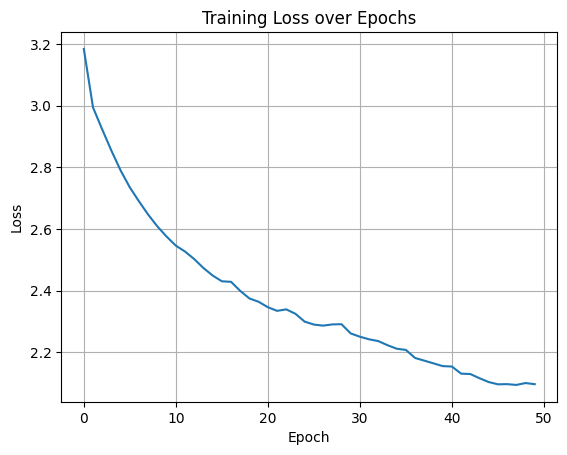

(SpeechRecognitionModel(
   (lstm): LSTM(40, 256, batch_first=True, bidirectional=True)
   (fc): Linear(in_features=512, out_features=62, bias=True)
 ),
 {'<blank>': 0,
  'S': 1,
  'h': 2,
  'e': 3,
  ' ': 4,
  'a': 5,
  'd': 6,
  'y': 7,
  'o': 8,
  'u': 9,
  'r': 10,
  'k': 11,
  's': 12,
  'i': 13,
  't': 14,
  'n': 15,
  'g': 16,
  'w': 17,
  'l': 18,
  '.': 19,
  'D': 20,
  "'": 21,
  'm': 22,
  'c': 23,
  'E': 24,
  'v': 25,
  ',': 26,
  'f': 27,
  'p': 28,
  'O': 29,
  'b': 30,
  '?': 31,
  'A': 32,
  'x': 33,
  'T': 34,
  'H': 35,
  'j': 36,
  'C': 37,
  'q': 38,
  'R': 39,
  'N': 40,
  'z': 41,
  'I': 42,
  'P': 43,
  'W': 44,
  '-': 45,
  'U': 46,
  'F': 47,
  'Y': 48,
  'B': 49,
  'M': 50,
  '!': 51,
  'J': 52,
  ':': 53,
  ';': 54,
  'G': 55,
  'V': 56,
  'L': 57,
  '"': 58,
  'K': 59,
  'X': 60,
  'Q': 61})

In [ ]:
dataset_path = '/content/timit/data/TRAIN'
trained_model, vocab = train_model(dataset_path)

##Тестирование

In [13]:
def preprocess_audio(audio_path):
    waveform, sr = torchaudio.load(audio_path)
    waveform = waveform.to(device)
    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.permute(0, 2, 1)

    return mfcc, waveform.size(1)

def predict(model, mfcc, vocab):
    with torch.no_grad():
        logits = model(mfcc)
        log_probs = nn.functional.log_softmax(logits, dim=2)

        predicted_ids = log_probs.argmax(dim=2).squeeze(0).cpu().numpy()

        blank_idx = vocab['<blank>']
        predicted_text = []
        prev_idx = None

        for idx in predicted_ids:
            if idx != blank_idx and idx != prev_idx:
                predicted_text.append(list(vocab.keys())[list(vocab.values()).index(idx)])
            prev_idx = idx

        return ''.join(predicted_text)


In [14]:
def calculate_wer(predicted: str, reference: str) -> float:

    predicted_words = predicted.split()
    reference_words = reference.split()

    d = np.zeros((len(predicted_words) + 1, len(reference_words) + 1))

    for i in range(len(predicted_words) + 1):
        d[i][0] = i
    for j in range(len(reference_words) + 1):
        d[0][j] = j

    for i in range(1, len(predicted_words) + 1):
        for j in range(1, len(reference_words) + 1):
            cost = 0 if predicted_words[i - 1] == reference_words[j - 1] else 1
            d[i][j] = min(d[i - 1][j] + 1,
                          d[i][j - 1] + 1,
                          d[i - 1][j - 1] + cost)

    return d[len(predicted_words)][len(reference_words)] / float(len(reference_words))

In [39]:
def evaluate_model(model, test_dataset, vocab):
    model.eval()
    total_wer = 0
    total_samples = len(test_dataset)
    blank_idx = vocab['<blank>']

    with torch.no_grad():
        for i in range(total_samples):
            audio, sr = test_dataset.get_audio(i)
            true_text = test_dataset.get_text(i)

            audio = audio.to(device)
            mfcc = mfcc_transform(audio.unsqueeze(0))
            mfcc = mfcc.permute(0, 2, 1)

            logits = model(mfcc)
            log_probs = nn.functional.log_softmax(logits, dim=2)
            predicted_ids = log_probs.argmax(dim=2).squeeze(0).cpu().numpy()

            predicted_text = []
            prev_idx = None
            for idx in predicted_ids:
                if idx != blank_idx and idx != prev_idx:
                    predicted_text.append(list(vocab.keys())[list(vocab.values()).index(idx)])
                prev_idx = idx

            predicted_text = ''.join(predicted_text)

            wer = calculate_wer(predicted_text, true_text)
            total_wer += wer

    avg_wer = total_wer / total_samples
    return avg_wer


In [20]:
dataset_path = '/content/timit/data/TRAIN'
dataloader, vocab = prepare_dataloader(dataset_path, batch_size=32)

Found 4620 utterances in /content/timit/data/TRAIN.


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeechRecognitionModel(input_dim=40, hidden_dim=256, output_dim=len(vocab))
model.load_state_dict(torch.load('/content/speech_recognition_model_attention.pth', map_location=device))
model = model.to(device)
model.eval()

<ipython-input-50-52c631c6a6f8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/speech_recognition_model_attention.pth', map_loca

SpeechRecognitionModel(
  (lstm): LSTM(40, 256, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (fc): Linear(in_features=512, out_features=62, bias=True)
)

In [23]:
audio_path = '/content/timit/data/TRAIN/DR1/FCJF0/SA1.WAV.wav'
mfcc, audio_len = preprocess_audio(audio_path)
predicted_text = predict(model, mfcc, vocab)
print(f"Predicted Text: {predicted_text}")


Predicted Text: She he had your dark sut in greasy wash water al year....


In [42]:
test_dataset = TimitDataset('timit/data/TEST/')
evaluate_model(model, test_dataset, vocab)

Found 1680 utterances in timit/data/TEST/.


0.8751449196259289

##Эээээксперименты

###№1

In [43]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.fc(x)
        return x

In [ ]:
def setup_training(input_dim, hidden_dim, output_dim, lr):
    model = SpeechRecognitionModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)

    return model, optimizer, criterion

In [ ]:
def train_model(dataset_path, epochs=50, batch_size=32, lr=0.001):
    dataloader, vocab = prepare_dataloader(dataset_path, batch_size)
    model, optimizer, criterion = setup_training(input_dim=40, hidden_dim=256, output_dim=len(vocab), lr=lr)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_history = []
    for epoch in range(epochs):
        epoch_loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
        scheduler.step()
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), 'speech_recognition_model.pth')
    plot_loss(loss_history)

    return model, vocab

Found 4620 utterances in /content/timit/data/TRAIN.


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 1, Loss: 3.2897


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 2, Loss: 3.0094


Training: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch 3, Loss: 2.9596


Training: 100%|██████████| 145/145 [00:50<00:00,  2.85it/s]


Epoch 4, Loss: 2.9176


Training: 100%|██████████| 145/145 [00:49<00:00,  2.93it/s]


Epoch 5, Loss: 2.8783


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 6, Loss: 2.8398


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 7, Loss: 2.8056


Training: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch 8, Loss: 2.7721


Training: 100%|██████████| 145/145 [00:50<00:00,  2.89it/s]


Epoch 9, Loss: 2.7448


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 10, Loss: 2.7167


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 11, Loss: 2.6825


Training: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch 12, Loss: 2.6615


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 13, Loss: 2.6433


Training: 100%|██████████| 145/145 [00:49<00:00,  2.91it/s]


Epoch 14, Loss: 2.6301


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 15, Loss: 2.6145


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 16, Loss: 2.6040


Training: 100%|██████████| 145/145 [00:49<00:00,  2.96it/s]


Epoch 17, Loss: 2.6071


Training: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch 18, Loss: 2.5848


Training: 100%|██████████| 145/145 [00:50<00:00,  2.90it/s]


Epoch 19, Loss: 2.5703


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 20, Loss: 2.5570


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 21, Loss: 2.5416


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 22, Loss: 2.5328


Training: 100%|██████████| 145/145 [00:49<00:00,  2.95it/s]


Epoch 23, Loss: 2.5267


Training: 100%|██████████| 145/145 [00:52<00:00,  2.74it/s]


Epoch 24, Loss: 2.5191


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 25, Loss: 2.5117


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 26, Loss: 2.5040


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 27, Loss: 2.4967


Training: 100%|██████████| 145/145 [00:50<00:00,  2.84it/s]


Epoch 28, Loss: 2.4902


Training: 100%|██████████| 145/145 [00:49<00:00,  2.95it/s]


Epoch 29, Loss: 2.4831


Training: 100%|██████████| 145/145 [00:49<00:00,  2.91it/s]


Epoch 30, Loss: 2.4760


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 31, Loss: 2.4672


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 32, Loss: 2.4615


Training: 100%|██████████| 145/145 [00:50<00:00,  2.87it/s]


Epoch 33, Loss: 2.4567


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 34, Loss: 2.4539


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 35, Loss: 2.4483


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 36, Loss: 2.4448


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 37, Loss: 2.4402


Training: 100%|██████████| 145/145 [00:51<00:00,  2.82it/s]


Epoch 38, Loss: 2.4365


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 39, Loss: 2.4329


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 40, Loss: 2.4298


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 41, Loss: 2.4244


Training: 100%|██████████| 145/145 [00:51<00:00,  2.79it/s]


Epoch 42, Loss: 2.4209


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 43, Loss: 2.4195


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 44, Loss: 2.4167


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 45, Loss: 2.4155


Training: 100%|██████████| 145/145 [00:50<00:00,  2.89it/s]


Epoch 46, Loss: 2.4134


Training: 100%|██████████| 145/145 [00:51<00:00,  2.79it/s]


Epoch 47, Loss: 2.4105


Training: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch 48, Loss: 2.4091


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 49, Loss: 2.4074


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 50, Loss: 2.4058


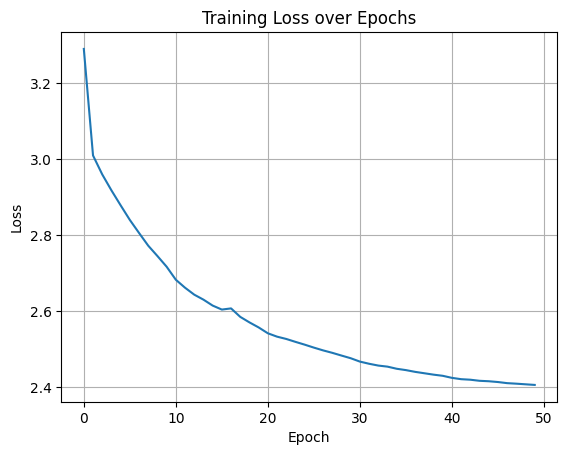

In [ ]:
dataset_path = '/content/timit/data/TRAIN'
trained_model, vocab = train_model(dataset_path)

In [26]:
audio_path = '/content/timit/data/TRAIN/DR1/FCJF0/SA1.WAV.wav'
mfcc, audio_len = preprocess_audio(audio_path)
predicted_text = predict(model, mfcc, vocab)
print(f"Predicted Text: {predicted_text}")

Predicted Text: She had your dark suit in greasy wash waer aea


In [45]:
test_dataset = TimitDataset('timit/data/TEST/')
evaluate_model(model, test_dataset, vocab)

Found 1680 utterances in timit/data/TEST/.


0.8627649446172768

###№2

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler):
    model.train()
    total_loss = 0

    for audios, audio_lens, texts, text_lens in tqdm(dataloader, desc="Training"):
        audios, texts, audio_lens, text_lens = (
            audios.to(device),
            texts.to(device),
            audio_lens.to(device),
            text_lens.to(device),
        )

        audios = torch.stack([mfcc_transform(audio) for audio in audios])
        audio_lens = audio_lens // audios.shape[2]
        audios = audios.permute(0, 2, 1)

        with torch.amp.autocast('cuda'):
            logits = model(audios)
            log_probs = nn.functional.log_softmax(logits, dim=2).transpose(0, 1)
            loss = criterion(log_probs, texts, audio_lens, text_lens)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def train_model(dataset_path, epochs=100, batch_size=32, lr=0.001):
    dataloader, vocab = prepare_dataloader(dataset_path, batch_size)
    model, optimizer, criterion, scheduler = setup_training(
        input_dim=40, hidden_dim=256, output_dim=len(vocab), lr=lr
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    scaler = torch.cuda.amp.GradScaler()

    loss_history = []
    for epoch in range(epochs):
        epoch_loss = train_one_epoch(model, dataloader, optimizer, criterion, device, scaler)
        scheduler.step(epoch_loss)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), 'speech_recognition_model_100epochs.pth')
    plot_loss(loss_history)

    return model, vocab

Found 4620 utterances in /content/timit/data/TRAIN.


<ipython-input-31-eccec00e418d>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 1, Loss: 3.2269


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 2, Loss: 3.0062


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 3, Loss: 2.9425


Training: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch 4, Loss: 2.8792


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 5, Loss: 2.8132


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 6, Loss: 2.7544


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 7, Loss: 2.7051


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 8, Loss: 2.6593


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 9, Loss: 2.6233


Training: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch 10, Loss: 2.6014


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 11, Loss: 2.5641


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 12, Loss: 2.5346


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 13, Loss: 2.5119


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 14, Loss: 2.4854


Training: 100%|██████████| 145/145 [00:47<00:00,  3.05it/s]


Epoch 15, Loss: 2.4708


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 16, Loss: 2.4466


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 17, Loss: 2.4342


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 18, Loss: 2.4195


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 19, Loss: 2.4063


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 20, Loss: 2.3945


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 21, Loss: 2.3845


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 22, Loss: 2.3804


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 23, Loss: 2.3634


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 24, Loss: 2.3528


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 25, Loss: 2.3445


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 26, Loss: 2.3347


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 27, Loss: 2.3124


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 28, Loss: 2.3098


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 29, Loss: 2.3084


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 30, Loss: 2.3064


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 31, Loss: 2.2804


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 32, Loss: 2.2624


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 33, Loss: 2.2653


Training: 100%|██████████| 145/145 [00:47<00:00,  3.05it/s]


Epoch 34, Loss: 2.2661


Training: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch 35, Loss: 2.2558


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 36, Loss: 2.2433


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 37, Loss: 2.2409


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 38, Loss: 2.2281


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 39, Loss: 2.2210


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 40, Loss: 2.2044


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 41, Loss: 2.2106


Training: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch 42, Loss: 2.1947


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 43, Loss: 2.1815


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 44, Loss: 2.1825


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 45, Loss: 2.1783


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 46, Loss: 2.1676


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 47, Loss: 2.1556


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 48, Loss: 2.1427


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 49, Loss: 2.1500


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 50, Loss: 2.1370


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 51, Loss: 2.1242


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 52, Loss: 2.1330


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 53, Loss: 2.1253


Training: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch 54, Loss: 2.1006


Training: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch 55, Loss: 2.0953


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 56, Loss: 2.1119


Training: 100%|██████████| 145/145 [00:50<00:00,  2.90it/s]


Epoch 57, Loss: 2.1208


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 58, Loss: 2.0827


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 59, Loss: 2.0769


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 60, Loss: 2.0707


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 61, Loss: 2.1020


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 62, Loss: 2.0783


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 63, Loss: 2.0604


Training: 100%|██████████| 145/145 [00:49<00:00,  2.95it/s]


Epoch 64, Loss: 2.0459


Training: 100%|██████████| 145/145 [00:49<00:00,  2.96it/s]


Epoch 65, Loss: 2.0368


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 66, Loss: 2.0310


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 67, Loss: 2.0255


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 68, Loss: 2.0199


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 69, Loss: 2.0614


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 70, Loss: 2.0354


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 71, Loss: 2.0385


Training: 100%|██████████| 145/145 [00:50<00:00,  2.85it/s]


Epoch 72, Loss: 2.0284


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 73, Loss: 2.0355


Training: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch 74, Loss: 2.0049


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 75, Loss: 1.9810


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 76, Loss: 1.9845


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 77, Loss: 1.9774


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 78, Loss: 1.9550


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 79, Loss: 1.9507


Training: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch 80, Loss: 1.9331


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 81, Loss: 1.9688


Training: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch 82, Loss: 1.9351


Training: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]


Epoch 83, Loss: 1.9166


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 84, Loss: 1.9051


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 85, Loss: 1.8970


Training: 100%|██████████| 145/145 [00:49<00:00,  2.91it/s]


Epoch 86, Loss: 1.8927


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 87, Loss: 1.8859


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 88, Loss: 1.8772


Training: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]


Epoch 89, Loss: 1.9525


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 90, Loss: 1.8902


Training: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]


Epoch 91, Loss: 1.8763


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 92, Loss: 1.8771


Training: 100%|██████████| 145/145 [00:49<00:00,  2.90it/s]


Epoch 93, Loss: 1.8570


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 94, Loss: 1.8454


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 95, Loss: 1.8373


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 96, Loss: 1.8306


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 97, Loss: 1.8432


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 98, Loss: 1.8403


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 99, Loss: 1.8220


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 100, Loss: 1.8174


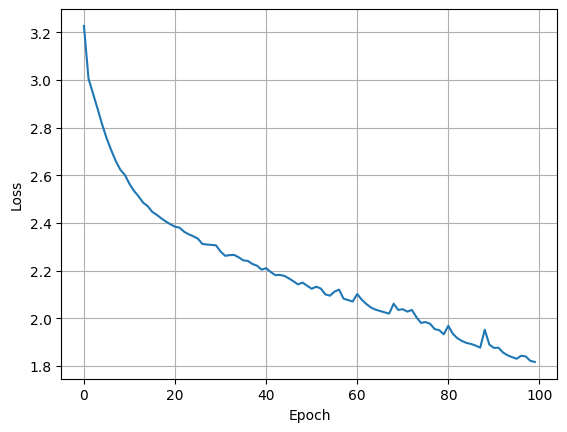

In [ ]:
dataset_path = '/content/timit/data/TRAIN'
trained_model, vocab = train_model(dataset_path)

In [34]:
audio_path = '/content/timit/data/TRAIN/DR1/FCJF0/SA1.WAV.wav'
mfcc, audio_len = preprocess_audio(audio_path)
predicted_text = predict(model, mfcc, vocab)
print(f"Predicted Text: {predicted_text}")

Predicted Text: She he had your dark suit in greasy wash water al year.r.e..............


In [48]:
test_dataset = TimitDataset('timit/data/TEST/')
evaluate_model(model, test_dataset, vocab)

Found 1680 utterances in timit/data/TEST/.


1.1391955299019363

###№3

In [49]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead=4, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2, num_heads=nhead)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.permute(1, 0, 2)
        x, _ = self.attention(x, x, x)
        x = x.permute(1, 0, 2)
        x = self.fc(x)
        return x

In [ ]:
def setup_training(input_dim, hidden_dim, output_dim, lr):
    model = SpeechRecognitionModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    return model, optimizer, criterion, scheduler

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler):
    model.train()
    total_loss = 0

    for audios, audio_lens, texts, text_lens in tqdm(dataloader, desc="Training"):
        audios, texts, audio_lens, text_lens = (
            audios.to(device),
            texts.to(device),
            audio_lens.to(device),
            text_lens.to(device),
        )

        audios = torch.stack([mfcc_transform(audio) for audio in audios])
        audio_lens = audio_lens // audios.shape[2]
        audios = audios.permute(0, 2, 1)

        with torch.cuda.amp.autocast():
            logits = model(audios)
            log_probs = nn.functional.log_softmax(logits, dim=2).transpose(0, 1)
            loss = criterion(log_probs, texts, audio_lens, text_lens)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
def train_model(dataset_path, epochs=100, batch_size=32, lr=0.001):
    dataloader, vocab = prepare_dataloader(dataset_path, batch_size)
    model, optimizer, criterion, scheduler = setup_training(
        input_dim=40, hidden_dim=256, output_dim=len(vocab), lr=lr
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    scaler = torch.cuda.amp.GradScaler()

    loss_history = []
    for epoch in range(epochs):
        epoch_loss = train_one_epoch(model, dataloader, optimizer, criterion, device, scaler)
        scheduler.step(epoch_loss)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), 'speech_recognition_model_attention.pth')
    plot_loss(loss_history)

    return model, vocab

Found 4620 utterances in /content/timit/data/TRAIN.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-12-1f5d0c4b837f>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that exces

Epoch 1, Loss: 3.2106


Training: 100%|██████████| 145/145 [00:51<00:00,  2.84it/s]


Epoch 2, Loss: 2.9982


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 3, Loss: 2.8947


Training: 100%|██████████| 145/145 [00:51<00:00,  2.83it/s]


Epoch 4, Loss: 2.8292


Training: 100%|██████████| 145/145 [00:49<00:00,  2.93it/s]


Epoch 5, Loss: 2.7595


Training: 100%|██████████| 145/145 [00:49<00:00,  2.95it/s]


Epoch 6, Loss: 2.6864


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 7, Loss: 2.6330


Training: 100%|██████████| 145/145 [00:49<00:00,  2.90it/s]


Epoch 8, Loss: 2.5766


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 9, Loss: 2.5315


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 10, Loss: 2.4874


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 11, Loss: 2.4527


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 12, Loss: 2.4161


Training: 100%|██████████| 145/145 [00:50<00:00,  2.90it/s]


Epoch 13, Loss: 2.3814


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 14, Loss: 2.3590


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 15, Loss: 2.3371


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 16, Loss: 2.3152


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 17, Loss: 2.3028


Training: 100%|██████████| 145/145 [00:49<00:00,  2.91it/s]


Epoch 18, Loss: 2.2996


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 19, Loss: 2.2755


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 20, Loss: 2.2435


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 21, Loss: 2.2087


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 22, Loss: 2.1929


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 23, Loss: 2.1849


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 24, Loss: 2.1648


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 25, Loss: 2.1427


Training: 100%|██████████| 145/145 [00:49<00:00,  2.96it/s]


Epoch 26, Loss: 2.1321


Training: 100%|██████████| 145/145 [00:50<00:00,  2.85it/s]


Epoch 27, Loss: 2.1174


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 28, Loss: 2.1134


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 29, Loss: 2.1053


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 30, Loss: 2.0921


Training: 100%|██████████| 145/145 [00:49<00:00,  2.91it/s]


Epoch 31, Loss: 2.0757


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 32, Loss: 2.0735


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 33, Loss: 2.0674


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 34, Loss: 2.0568


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 35, Loss: 2.0512


Training: 100%|██████████| 145/145 [00:50<00:00,  2.89it/s]


Epoch 36, Loss: 2.0387


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 37, Loss: 2.0478


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 38, Loss: 2.0478


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 39, Loss: 2.0337


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 40, Loss: 2.0220


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 41, Loss: 1.9986


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 42, Loss: 1.9745


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 43, Loss: 1.9487


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 44, Loss: 1.9372


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 45, Loss: 1.9154


Training: 100%|██████████| 145/145 [00:49<00:00,  2.93it/s]


Epoch 46, Loss: 1.9102


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 47, Loss: 1.8977


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 48, Loss: 1.8968


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 49, Loss: 1.8942


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 50, Loss: 1.8748


Training: 100%|██████████| 145/145 [00:49<00:00,  2.92it/s]


Epoch 51, Loss: 1.8691


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 52, Loss: 1.8374


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 53, Loss: 1.8155


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 54, Loss: 1.7899


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 55, Loss: 1.7786


Training: 100%|██████████| 145/145 [00:50<00:00,  2.88it/s]


Epoch 56, Loss: 1.7752


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 57, Loss: 1.7513


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 58, Loss: 1.7425


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 59, Loss: 1.7395


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 60, Loss: 1.7381


Training: 100%|██████████| 145/145 [00:50<00:00,  2.87it/s]


Epoch 61, Loss: 1.7297


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 62, Loss: 1.7333


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 63, Loss: 1.7208


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 64, Loss: 1.7129


Training: 100%|██████████| 145/145 [00:49<00:00,  2.90it/s]


Epoch 65, Loss: 1.6964


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 66, Loss: 1.6785


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 67, Loss: 1.6817


Training: 100%|██████████| 145/145 [00:49<00:00,  2.95it/s]


Epoch 68, Loss: 1.6598


Training: 100%|██████████| 145/145 [00:49<00:00,  2.93it/s]


Epoch 69, Loss: 1.6383


Training: 100%|██████████| 145/145 [00:49<00:00,  2.90it/s]


Epoch 70, Loss: 1.6241


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 71, Loss: 1.6152


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 72, Loss: 1.6178


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 73, Loss: 1.6090


Training: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]


Epoch 74, Loss: 1.6087


Training: 100%|██████████| 145/145 [00:50<00:00,  2.90it/s]


Epoch 75, Loss: 1.6090


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 76, Loss: 1.5941


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 77, Loss: 1.5734


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 78, Loss: 1.5811


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 79, Loss: 1.5686


Training: 100%|██████████| 145/145 [00:50<00:00,  2.87it/s]


Epoch 80, Loss: 1.5438


Training: 100%|██████████| 145/145 [00:48<00:00,  3.01it/s]


Epoch 81, Loss: 1.5335


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 82, Loss: 1.5245


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 83, Loss: 1.5317


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 84, Loss: 1.5412


Training: 100%|██████████| 145/145 [00:50<00:00,  2.88it/s]


Epoch 85, Loss: 1.5328


Training: 100%|██████████| 145/145 [00:50<00:00,  2.88it/s]


Epoch 86, Loss: 1.5171


Training: 100%|██████████| 145/145 [00:48<00:00,  2.99it/s]


Epoch 87, Loss: 1.5008


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 88, Loss: 1.4914


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 89, Loss: 1.4756


Training: 100%|██████████| 145/145 [00:50<00:00,  2.90it/s]


Epoch 90, Loss: 1.4568


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 91, Loss: 1.4417


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 92, Loss: 1.4319


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 93, Loss: 1.4240


Training: 100%|██████████| 145/145 [00:48<00:00,  3.00it/s]


Epoch 94, Loss: 1.4188


Training: 100%|██████████| 145/145 [00:51<00:00,  2.84it/s]


Epoch 95, Loss: 1.4333


Training: 100%|██████████| 145/145 [00:48<00:00,  2.96it/s]


Epoch 96, Loss: 1.4229


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 97, Loss: 1.4224


Training: 100%|██████████| 145/145 [00:48<00:00,  2.98it/s]


Epoch 98, Loss: 1.4255


Training: 100%|██████████| 145/145 [00:50<00:00,  2.88it/s]


Epoch 99, Loss: 1.5020


Training: 100%|██████████| 145/145 [00:48<00:00,  2.97it/s]


Epoch 100, Loss: 1.4229


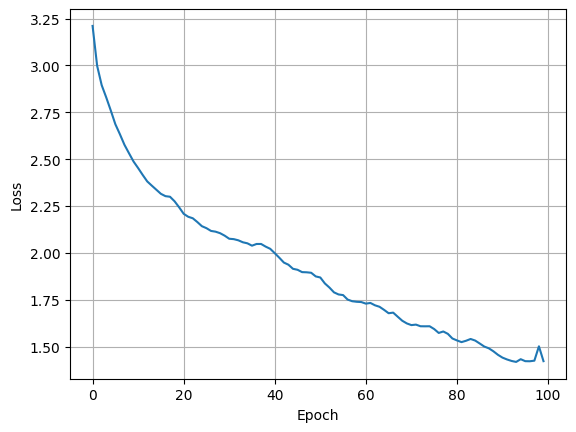

In [ ]:
dataset_path = '/content/timit/data/TRAIN'
trained_model, vocab = train_model(dataset_path)

In [37]:
audio_path = '/content/timit/data/TRAIN/DR1/FCJF0/SA1.WAV.wav'
mfcc, audio_len = preprocess_audio(audio_path)
predicted_text = predict(model, mfcc, vocab)
print(f"Predicted Text: {predicted_text}")

Predicted Text: She had your dr suit in greasy w ahsh water al l year  ea.ee


In [51]:
test_dataset = TimitDataset('timit/data/TEST/')
evaluate_model(model, test_dataset, vocab)

Found 1680 utterances in timit/data/TEST/.


1.0552535130213714